# NSL KDD binary classification with Transformer

I used it to classify the NSL-KDD dataset by making a slight change on the code I got from the [keras documentation page.](https://keras.io/examples/nlp/text_classification_with_transformer/)

## importing of required libraries 


In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

## Implement multi head self attention as a Keras layer


In [17]:

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output



## Implement a Transformer block as a layer


In [18]:

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)



## Implement embedding layer

Two seperate embedding layers, one for tokens, one for token index (positions).


In [19]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions



# prepare NSL KDD dataset


## reading CSV files

In [20]:
# c_names --->  column names
c_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels","difficulty_degree"]

train = pd.read_csv( "data/KDDTrain+.txt", names=c_names) # train file
test = pd.read_csv("data/KDDTest+.txt", names=c_names) # test file

## deletion of unnecessary feature (difficulty_degree)

In [21]:
del train["difficulty_degree"] 
del test["difficulty_degree"] 

## Converting object features to categories first and then to dummy tables (except "labels")

In [22]:
for i in c_names:
    print((train[i].dtypes))
    if train[i].dtypes==object:
        train[i] = train[i].astype('category')
        test[i] = test[i].astype('category')
        if i=="labels":
            break
        train=pd.get_dummies(train, columns=[i])
        test=pd.get_dummies(test, columns=[i])   

int64
object
object
object
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
float64
float64
float64
float64
float64
float64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
float64
object


## labels feature  converts to binary

In [23]:
# TRAIN
attack_or_not=[]
for i in train["labels"]:#it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
    if i =="normal":
        attack_or_not.append(1)
    else:
        attack_or_not.append(0)           
train["labels"]=attack_or_not

In [24]:
# TEST
attack_or_not=[]
for i in test["labels"]:#it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
    if i =="normal":
        attack_or_not.append(1)
    else:
        attack_or_not.append(0)           
test["labels"]=attack_or_not

## Synchronizing Test and Train datasets.
### Add "0" for the feature that does not exist in one of these two datasets.

In [25]:
f=list(train.columns)
e=list(test.columns)

for i in f:
    if i not in e:
        zero_data =pd.array(np.zeros(len(test["labels"]))) 
        print(len(zero_data))
        test[i] = zero_data
        print(i)
for i in e:
    if i not in f:
        zero_data = np.zeros(len(train["labels"]))
        train[i] = zero_data
        print(i)


22544
service_aol
22544
service_harvest
22544
service_http_2784
22544
service_http_8001
22544
service_red_i
22544
service_urh_i


## separation of features (data) and Label (target)

In [26]:
y = train["labels"] #this section separates the label and the data into two separate pieces, as Label=y Data=X 
del train["labels"] 
X = train

In [27]:
y_test = test["labels"] #this section separates the label and the data into two separate pieces, as Label=y Data=X 
del test["labels"] 
x_test=test


## Normalization and Standardization

In [28]:
X = preprocessing.scale(X)
X = preprocessing.normalize(X)

In [29]:
x_test = preprocessing.scale(x_test)
x_test = preprocessing.normalize(x_test)


## Separating Train data into two parts as train and validation

In [30]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)
print(len(x_train), "Training sequences",x_train.shape)
print(len(x_val), "Validation sequences",x_val.shape)
print(len(x_test), "Test sequences",x_test.shape)

100778 Training sequences (100778, 122)
25195 Validation sequences (25195, 122)
22544 Test sequences (22544, 122)


## Create classifier model using transformer layer

Transformer layer outputs one vector for each time step of our input sequence.
Here, we take the mean across all time steps and
use a feed forward network on top of it to classify text.


In [31]:
maxlen=122
vocab_size = 100000  # Only consider the top 20k words



embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)



2024-12-02 15:59:20.904979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-02 15:59:20.998438: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [32]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test , maxlen=maxlen)


## Train

In [36]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val)
)


Epoch 1/20
3150/3150 [==============================] - 50s 15ms/step - loss: 0.6908 - accuracy: 0.5345 - val_loss: 0.6908 - val_accuracy: 0.5346
Epoch 2/20
3150/3150 [==============================] - 46s 15ms/step - loss: 0.6908 - accuracy: 0.5346 - val_loss: 0.6908 - val_accuracy: 0.5346
Epoch 3/20
3150/3150 [==============================] - 52s 16ms/step - loss: 0.6908 - accuracy: 0.5346 - val_loss: 0.6908 - val_accuracy: 0.5346
Epoch 4/20
3150/3150 [==============================] - 51s 16ms/step - loss: 0.6908 - accuracy: 0.5346 - val_loss: 0.6908 - val_accuracy: 0.5346
Epoch 5/20
3150/3150 [==============================] - 49s 16ms/step - loss: 0.6908 - accuracy: 0.5345 - val_loss: 0.6908 - val_accuracy: 0.5346
Epoch 6/20
3150/3150 [==============================] - 55s 17ms/step - loss: 0.6908 - accuracy: 0.5346 - val_loss: 0.6908 - val_accuracy: 0.5346
Epoch 7/20
3150/3150 [==============================] - 63s 20ms/step - loss: 0.6908 - accuracy: 0.5346 - val_loss: 0.6908 -

## Evaluate

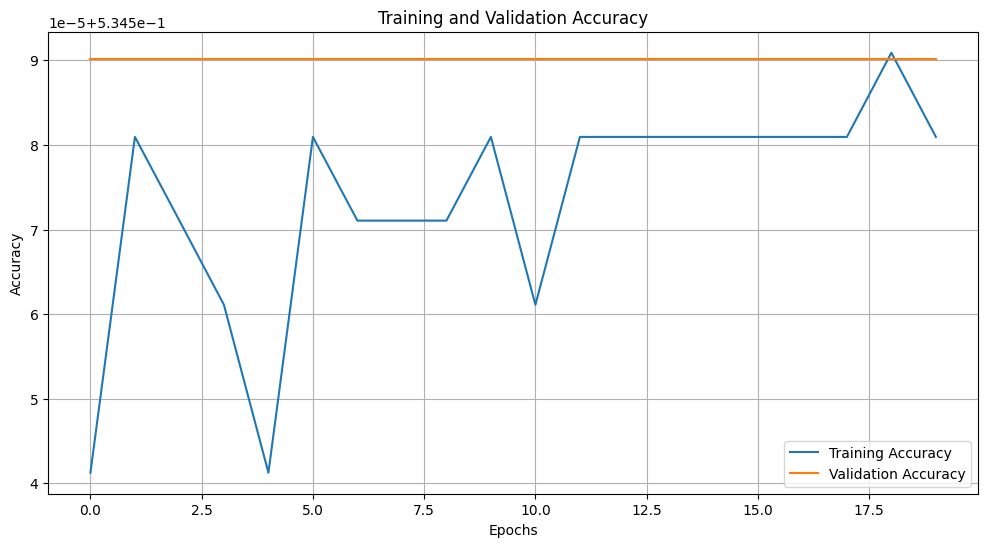

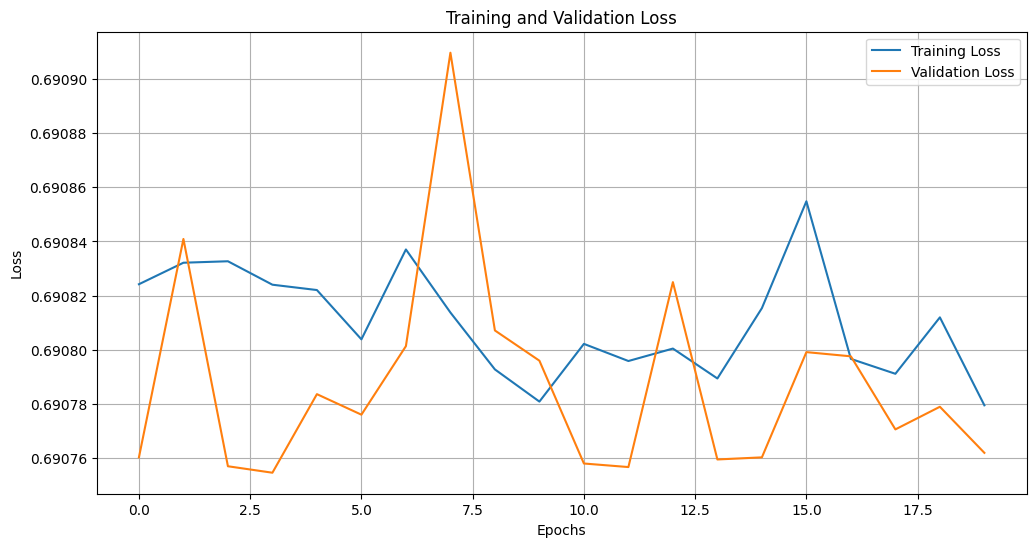

In [39]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [37]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.7060802578926086
Test accuracy: 0.43075764179229736


In [38]:
score = model.evaluate(x_val, y_val, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.6907620429992676
Test accuracy: 0.5345901846885681
